In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from PIL import Image
from tensorflow.keras.utils import plot_model # type: ignore
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
import warnings
warnings.filterwarnings("ignore", message=".*CuDNN.*")
warnings.filterwarnings("ignore", message=".*cuFFT.*")
warnings.filterwarnings("ignore", message=".*cuBLAS.*")
import os
# from tensorflow.keras.utils import np_utils
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import datasets, layers, models
from PIL import Image

2024-06-10 12:51:49.649183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 12:51:49.649303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 12:51:49.767648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIRS = [r'//kaggle//input//utkface-new//UTKFace']

In [3]:
image_paths = []
age_labels = []
gender_paths = []

for BASE_DIR in BASE_DIRS:
    for filename in tqdm(os.listdir(BASE_DIR)):
        temp = filename.split('_')
        if temp[0].isdigit():  # Check if the first part of the filename is a number
            age = int(temp[0])
            gender = int(temp[1])
            image_path = os.path.join(BASE_DIR, filename)
            image_paths.append(image_path)
            age_labels.append(age)
            gender_paths.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 234351.35it/s]


In [4]:
df =pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths,age_labels,gender_paths
df.head()
# print(df.head())
print(f"Dataframe: {df}")
gender_dict = {0:'Male', 1:'Female'}



Dataframe:                                                    image  age  gender
0      //kaggle//input//utkface-new//UTKFace/26_0_2_2...   26       0
1      //kaggle//input//utkface-new//UTKFace/22_1_1_2...   22       1
2      //kaggle//input//utkface-new//UTKFace/21_1_3_2...   21       1
3      //kaggle//input//utkface-new//UTKFace/28_0_0_2...   28       0
4      //kaggle//input//utkface-new//UTKFace/17_1_4_2...   17       1
...                                                  ...  ...     ...
23703  //kaggle//input//utkface-new//UTKFace/41_0_0_2...   41       0
23704  //kaggle//input//utkface-new//UTKFace/42_0_0_2...   42       0
23705  //kaggle//input//utkface-new//UTKFace/2_0_2_20...    2       0
23706  //kaggle//input//utkface-new//UTKFace/65_1_0_2...   65       1
23707  //kaggle//input//utkface-new//UTKFace/66_0_1_2...   66       0

[23708 rows x 3 columns]


Dataframe shape: (23708, 3)
First few rows of the dataframe:                                                image  age  gender
0  //kaggle//input//utkface-new//UTKFace/26_0_2_2...   26       0
1  //kaggle//input//utkface-new//UTKFace/22_1_1_2...   22       1
2  //kaggle//input//utkface-new//UTKFace/21_1_3_2...   21       1
3  //kaggle//input//utkface-new//UTKFace/28_0_0_2...   28       0
4  //kaggle//input//utkface-new//UTKFace/17_1_4_2...   17       1


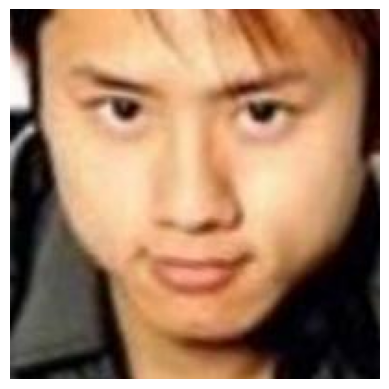

In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_paths

# Debug print to check if the dataframe is populated correctly
print(f"Dataframe shape: {df.shape}")
print(f"First few rows of the dataframe: {df.head()}")

if not df.empty:
    gender_dict = {0: 'Male', 1: 'Female'}

    try:
        img = Image.open(df['image'][0])
        plt.axis('off')
        plt.imshow(img)
        plt.show()
    except Exception as e:
        print(f"Error opening image: {e}")
else:
    print("Dataframe is empty. No images found.")

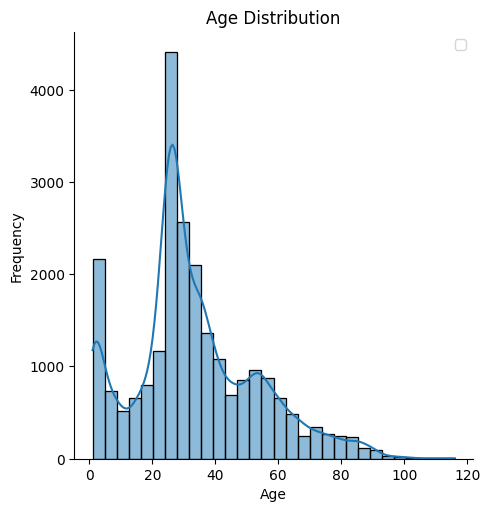

In [6]:
sns.displot(df['age'],kde=True, bins=30)
plt.title('Age Distribution')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [7]:
plt.figure(figsize=(25,25))
files = df.iloc[0:25]

<Figure size 2500x2500 with 0 Axes>

In [9]:
def extract_feature(images):
    features = []
    for image in tqdm(images):
        # Load image and convert to grayscale
        img = Image.open(image).convert('L')
        # Resize image
        img = img.resize((128, 128), Image.BILINEAR)  # Use Image.ANTIALIAS

        img = np.array(img)
        features.append(img)
    
    features = np.array(features)

    features = features.reshape(len(features), 128, 128, 1)
    return features

In [10]:
X = extract_feature(df['image'])

print(f"X_shape: \t{X.shape}")
X = X / 255.0 #normalize the  image

y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
print("Shape of y_gender:", y_gender.shape)
print("Shape of y_age:", y_age.shape)

100%|██████████| 23708/23708 [02:00<00:00, 196.68it/s]


X_shape: 	(23708, 128, 128, 1)
Shape of y_gender: (23708,)
Shape of y_age: (23708,)


In [11]:
input_shape = (128,128,1)

inputs = Input(input_shape) 

#convolution layers
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp1)
maxp2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp2)
maxp3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp3)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(maxp4)

# Fully connected layers
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(256, activation='relu')(flatten)

dropout1 = Dropout(0.3)(dense1)
dropout2 = Dropout(0.3)(dense2)

# Output layers
output1 = Dense(1, activation='sigmoid', name='gender_out')(dropout1)
output2 = Dense(1, activation='relu', name='age_out')(dropout2)

model = Model(inputs=inputs, outputs=[output1, output2])


model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Concatenate y_gender and y_age into a single array
y_combined = np.column_stack((y_gender, y_age))

# Split the dataset into training and temporary sets
X_train, X_temp, y_combined_train, y_combined_temp = train_test_split(X, y_combined, test_size=0.2, random_state=42)

# Từ phần còn lại, chia thành 50% testing và 50% validation
X_test, X_val, y_combined_test, y_combined_val = train_test_split(X_temp, y_combined_temp, test_size=0.5, random_state=42)

# Split y_combined back into y_gender and y_age
y_train_gender, y_train_age = y_combined_train[:, 0], y_combined_train[:, 1]
y_test_gender, y_test_age = y_combined_test[:, 0], y_combined_test[:, 1]
y_val_gender, y_val_age = y_combined_val[:, 0], y_combined_val[:, 1]

In [13]:
from keras.callbacks import LearningRateScheduler

model_path = './best_model.keras'

checkpointer = ModelCheckpoint(
    filepath=model_path,
    monitor='val_gender_out_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

model.compile(loss=['binary_crossentropy', 'mae'], 
              optimizer='adam', 
              metrics=['accuracy', 'mae'])

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [14]:
total_images = len(image_paths)
print(f"Total number of images: {total_images}")

# Compute number of images in each set
train_images = len(X_train)
validation_images = len(X_val)
test_images = len(X_test)

print(f"Number of training images: {train_images}")
print(f"Number of validation images: {validation_images}")
print(f"Number of test images: {test_images}")


Total number of images: 23708
Number of training images: 18966
Number of validation images: 2371
Number of test images: 2371


In [15]:
import tensorflow as tf

tf.config.run_functions_eagerly(True)

# Training model
history = model.fit(x=X_train, y=[y_train_gender, y_train_age], batch_size=128, epochs=100, validation_data=(X_val, [y_val_gender, y_val_age]),callbacks = [annealer, checkpointer])

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - age_out_mae: 18.3632 - gender_out_accuracy: 0.5402 - loss: 19.1445
Epoch 1: val_gender_out_accuracy improved from -inf to 0.57149, saving model to ./best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - age_out_mae: 18.3497 - gender_out_accuracy: 0.5402 - loss: 19.1305 - val_age_out_mae: 14.7312 - val_gender_out_accuracy: 0.5715 - val_loss: 15.4144 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - age_out_mae: 14.6372 - gender_out_accuracy: 0.5944 - loss: 15.2973
Epoch 2: val_gender_out_accuracy improved from 0.57149 to 0.72838, saving model to ./best_model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - age_out_mae: 14.6334 - gender_out_accuracy: 0.5948 - loss: 15.2932 - val_age_out_mae: 12.5516 - val_gender_out_accuracy: 0.7284 - val_loss: 13.0847 - learning_rate: 9.0000e-04
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - age_out_mae: 12.0331 - gender_out_accuracy: 0.7431 - l

In [16]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

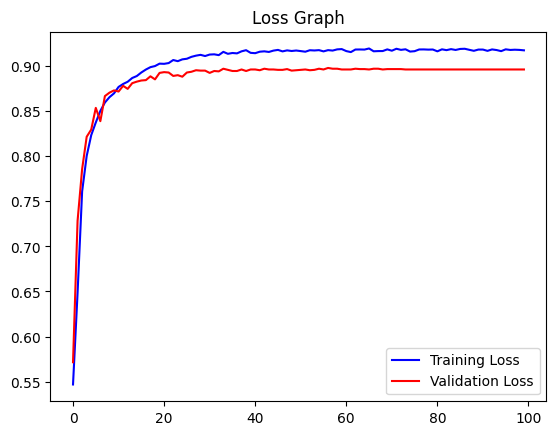

In [17]:
plt.plot(epochs, acc, 'b', label='Training Loss')
plt.plot(epochs, val_acc, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

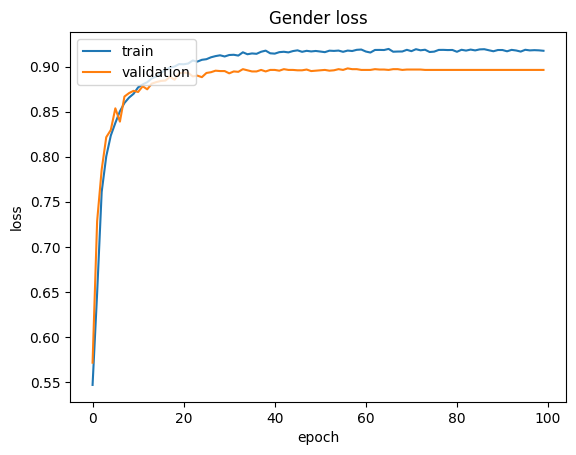

In [18]:
plt.plot(history.history['gender_out_accuracy'])
plt.plot(history.history['val_gender_out_accuracy'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


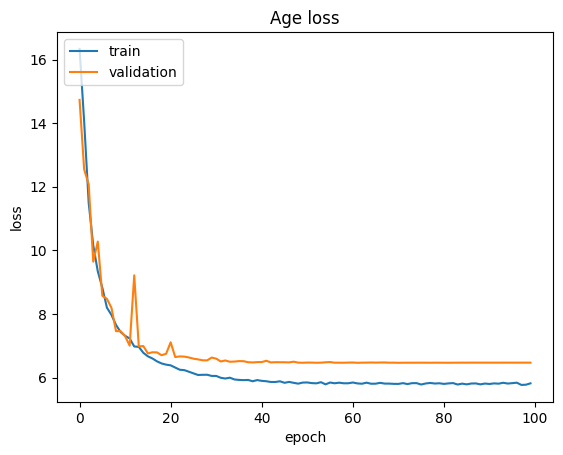

In [19]:
plt.plot(history.history['age_out_mae'])
plt.plot(history.history['val_age_out_mae'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Original Gender: 	Male 	 Original Age: 	28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Predicted Gender: 	Male	 Predicted Age 	27


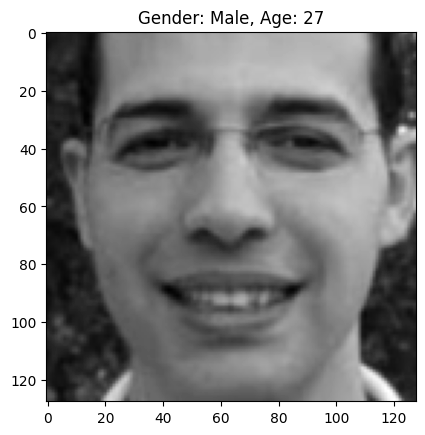

In [20]:
image_index = 3000
print(f"Original Gender: \t{gender_dict[y_gender[image_index]]} \t Original Age: \t{y_age[image_index]}")

pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[int(round(pred[0][0][0]))]  
pred_age = round(pred[1][0][0])
print(f"Predicted Gender: \t{pred_gender}\t Predicted Age \t{pred_age}")
plt.title(f'Gender: {pred_gender}, Age: {pred_age}')
plt.imshow(X[image_index].reshape(128,128), cmap='gray') 
plt.show()  


Original Gender: 	Female 	 Original Age: 	22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Gender: 	Female	 Predicted Age 	25


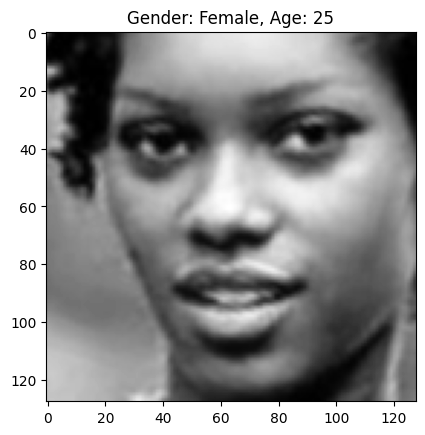

In [21]:
image_index = 50
print(f"Original Gender: \t{gender_dict[y_gender[image_index]]} \t Original Age: \t{y_age[image_index]}")

pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[int(round(pred[0][0][0]))]  
pred_age = round(pred[1][0][0])
print(f"Predicted Gender: \t{pred_gender}\t Predicted Age \t{pred_age}")
plt.title(f'Gender: {pred_gender}, Age: {pred_age}')
plt.imshow(X[image_index].reshape(128,128), cmap='gray') 
plt.show()  

Original Gender: 	Female 	 Original Age: 	23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Gender: 	Female	 Predicted Age 	30


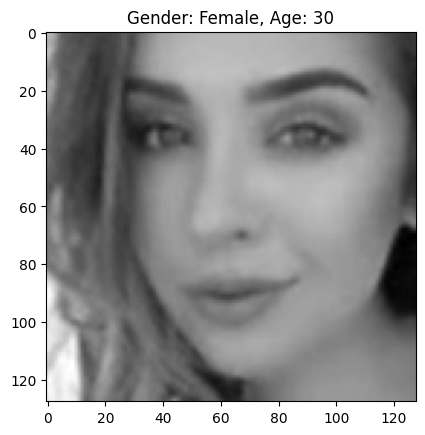

In [22]:
image_index = 35
print(f"Original Gender: \t{gender_dict[y_gender[image_index]]} \t Original Age: \t{y_age[image_index]}")

pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[int(round(pred[0][0][0]))]  
pred_age = round(pred[1][0][0])
print(f"Predicted Gender: \t{pred_gender}\t Predicted Age \t{pred_age}")
plt.title(f'Gender: {pred_gender}, Age: {pred_age}')
plt.imshow(X[image_index].reshape(128,128), cmap='gray') 
plt.show()  